# Importing libraries, loading and transforming data

In [1]:

!pip install -U -q mlflow datasets>=2.14.5 nlp 2>/dev/null

In [2]:
import pandas as pd  
import gc  
import re 
import numpy as np  

import warnings 
warnings.filterwarnings("ignore") 

import torch 
from transformers import AutoModel, AutoTokenizer 
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding 
from transformers import AutoModelForSequenceClassification 

from nlp import Dataset 
from imblearn.over_sampling import RandomOverSampler  
import datasets  
from datasets import Dataset, Image, ClassLabel  
from transformers import pipeline 
from bs4 import BeautifulSoup  

import matplotlib.pyplot as plt  
import itertools  
from sklearn.metrics import ( 
    accuracy_score,  
    roc_auc_score, 
    confusion_matrix,  
    classification_report, 
    f1_score 
)

from datasets import load_metric 

from tqdm import tqdm  
tqdm.pandas() 

In [3]:

train_fraction = 0.8

num_train_epochs = 10

learning_rate = 3e-7

train_batch_size = 8

eval_batch_size = 64

warmup_steps = 50

weight_decay = 0.02

BERT_MODEL = "distilbert-base-cased"

output_dir = "sms-spam-detection-distilbert"

In [12]:
iswpadf=pd.read_csv("/kaggle/input/iswpa-dataset/IWSPA-AP-Parsed.csv", encoding='latin-1')
iswpadf = iswpadf.rename(columns={'is_phishing': 'label', 'email_body': 'title'}) # Rename the columns to standard ones
iswpadf

df_1 = iswpadf[iswpadf['label'] == 1]
df_0 = iswpadf[iswpadf['label'] == 0]

# Determine 10% sample size for each
sample_size_1 = int(len(df_1) * 0.10)
sample_size_0 = int(len(df_0) * 0.10)

sampled_1 = df_1.sample(sample_size_1)
sampled_0 = df_0.sample(sample_size_0)

new_df = pd.concat([sampled_1, sampled_0])
new_df=new_df[['label', 'title']]


In [13]:
%%time
df = pd.read_csv("/kaggle/input/radev-data/fraud_email_.csv", encoding='latin-1')
df = df.rename(columns={'Class': 'label', 'Text': 'title'}) 

df=pd.concat([df,new_df])
print(df)
item0 = df.shape[0] 
df = df.drop_duplicates() 
item1 = df.shape[0]  
print(f"There are {item0-item1} duplicates found in the dataset") 

df = df.rename(columns={'Class': 'label', 'Text': 'title'})

df = df[['label', 'title']]  
df['label'] = df['label'].astype('str')


df = df[~df['title'].isnull()] 
df = df[~df['label'].isnull()]  

print(df.shape)  
df.sample(5).T  



                                                   title  label
0      Supply Quality China's EXCLUSIVE dimensions at...      1
1                             over. SidLet me know. Thx.      0
2      Dear Friend,Greetings to you.I wish to accost ...      1
3      MR. CHEUNG PUIHANG SENG BANK LTD.DES VOEUX RD....      1
4              Not a surprising assessment from Embassy.      0
...                                                  ...    ...
1523   Great. One domain.com below. Hit RR2 when you'...      0
2720   This is the letter to the editor that I placed...      0
3217   This email is intended to provide a brief summ...      0
10248  Rabbi Feintuch, I recently read an article in ...      0
10293  Let me know if you have any edits Alex Shapiro...      0

[12958 rows x 2 columns]
There are 1712 duplicates found in the dataset
(11245, 2)
CPU times: user 166 ms, sys: 11.9 ms, total: 178 ms
Wall time: 177 ms


,6547,1382,1308,10532,3864
label,0,1,0,0,0
title,"Hi Keith, Busy, busy, busy as usual. Here are ...","Beloved,I am sorry for my unannounced communic...",Need links for a couple of these. Thanks! SL: ...,Below is Palau's statement on the recent meeti...,Cc: Abedin HumaHappy to chat at your convenience


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11245 entries, 0 to 10293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11245 non-null  object
 1   title   11245 non-null  object
dtypes: object(2)
memory usage: 263.6+ KB


In [15]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(df[['label']])

print(classes)

weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['label'])

class_weights = dict(zip(classes, weights))

print(class_weights)

['0' '1']
{'0': 0.8268382352941176, '1': 1.264904386951631}


In [16]:
labels_list = sorted(list(df['label'].unique()))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: '0', 1: '1'} 

Mapping of Labels to IDs: {'0': 0, '1': 1}


In [17]:
ordered_weigths = [class_weights[x] for x in id2label.values()]
ordered_weigths

[0.8268382352941176, 1.264904386951631]

In [18]:
dataset = Dataset.from_pandas(df)

In [19]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=1-train_fraction, shuffle=True) # , stratify_by_column="label"

df_train = dataset['train']

df_test = dataset['test']

Map:   0%|          | 0/11245 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/11245 [00:00<?, ? examples/s]

In [20]:
del df

gc.collect()

11806

In [21]:

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [22]:

def preprocess_function(examples):
    # The main task of this function is to tokenize the text data in the 'title' column of the examples.
    # Tokenization is the process of breaking down text into smaller units, such as words or subwords.
    # In this case, the tokenizer is applied to each 'title' in the examples.

    # The 'truncation=True' parameter indicates that if a title is too long to fit within the model's maximum input length,
    # it should be truncated to fit. Truncation can help ensure that the input data is within the model's capacity.

    return tokenizer(examples["title"], truncation=True)


df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/8996 [00:00<?, ? examples/s]

Map:   0%|          | 0/2249 [00:00<?, ? examples/s]

In [23]:
df_train = df_train.remove_columns(['title'])

df_test = df_test.remove_columns(['title'])

In [24]:
df_train

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 8996
})

In [25]:
df_test

Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2249
})

In [26]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
tokenizer.decode(df_train[0]['input_ids'])

'[CLS] FROM MR JOHNSON MUGABE = 2E E - MAIL = 3B mm = 5Fm = 5F17johnson = 40yahoo = 2Ecom = 2EauDEAR SIR = 2C Compliments of the day = 2CI understand quite well that this message will sound so strange to you but it is a very serious matter that we need to tackle together very urgent = 2E Before i proceed further = 2CLet me formally introduce myself to you = 2EI am MR = 2E JOHNSON MUGABE = 2C 30 years of age = 2C the first adopted son of president Robert Mugabe = 2C the current Zimbabwean President = 2E I am contacting you today for an urgent assistance to transfer into your account the sum of US $ 19 = 2E8 = 28 NINTEEN POINT EIGHT MILION STATES DOLLARS = 29 = 2E I hope that you may be aware of the recent differences that is going on rigth now between my father and the opposition party in my country = 2C this also brought about the commonwealth community sanctioning my father and freezing all his foreign account both in America and britain = 2EThis decision was carried out during the 4 

# Loading and training model

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=len(labels_list),
    output_attentions=False, 
    output_hidden_states=False 
)

model.config.id2label = id2label  
model.config.label2id = label2id  

print(model.num_parameters(only_trainable=True) / 1e6)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


65.783042


In [29]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
   
    logits, labels = eval_pred
    
    
    predictions = np.argmax(logits, axis=-1)
    
    
    accuracy = metric.compute(predictions=predictions, references=labels)
    
    return accuracy

In [30]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(ordered_weigths, device=model.device).float())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [31]:
# Create TrainingArguments to configure the training process
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save the model checkpoints and logs
    logging_dir='./logs',  # Directory to store training logs
    num_train_epochs=num_train_epochs,  # Number of training epochs
    per_device_train_batch_size=train_batch_size,  # Batch size for training data
    per_device_eval_batch_size=eval_batch_size,  # Batch size for evaluation data
    logging_strategy='steps',  # Logging frequency during training (steps or epoch)
    logging_first_step=True,  # Log the first training step
    load_best_model_at_end=True,  # Load the best model at the end of training
    logging_steps=1,  # Log every training step (useful for debugging)
    learning_rate=learning_rate, # Set the learning rate for the optimizer.
    evaluation_strategy='epoch',  # Evaluation frequency (epoch or steps)
    warmup_steps=warmup_steps,  # Number of warmup steps for the learning rate
    weight_decay=weight_decay,  # Weight decay for regularization
    eval_steps=1,  # Evaluate every training step (useful for debugging)
    save_strategy='epoch',  # Save model checkpoints every epoch
    save_total_limit=1,  # Limit the number of saved checkpoints to save space
    report_to="mlflow",  # Log training metrics to MLflow
)


trainer = WeightedTrainer(
    model=model, 
    args=training_args,  
    compute_metrics=compute_metrics, 
    train_dataset=df_train,
    eval_dataset=df_test, 
    data_collator=data_collator  
)

In [32]:
trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.7017505764961243,
 'eval_accuracy': 0.3588261449533126,
 'eval_runtime': 22.673,
 'eval_samples_per_second': 99.193,
 'eval_steps_per_second': 1.588}

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.925600,0.402420,0.873277
2,0.137400,0.241697,0.935082
3,0.059000,0.153372,0.956870
4,0.067000,0.123226,0.965318
5,0.007900,0.110475,0.970209
6,0.010200,0.103641,0.973321
7,0.010500,0.098923,0.975989
8,0.006900,0.098356,0.977768
9,0.007400,0.096058,0.977768
10,0.009800,0.095681,0.978657


TrainOutput(global_step=11250, training_loss=0.17132030871671936, metrics={'train_runtime': 2743.5287, 'train_samples_per_second': 32.79, 'train_steps_per_second': 4.101, 'total_flos': 1.161209734069272e+16, 'train_loss': 0.17132030871671936, 'epoch': 10.0})

In [34]:
trainer.evaluate()

{'eval_loss': 0.09568127989768982,
 'eval_accuracy': 0.9786571809693198,
 'eval_runtime': 20.9996,
 'eval_samples_per_second': 107.097,
 'eval_steps_per_second': 1.714,
 'epoch': 10.0}

In [35]:
outputs = trainer.predict(df_test)

print(outputs.metrics)

{'test_loss': 0.09568127989768982, 'test_accuracy': 0.9786571809693198, 'test_runtime': 21.1364, 'test_samples_per_second': 106.404, 'test_steps_per_second': 1.703}


Accuracy: 0.9787
F1 Score: 0.9777


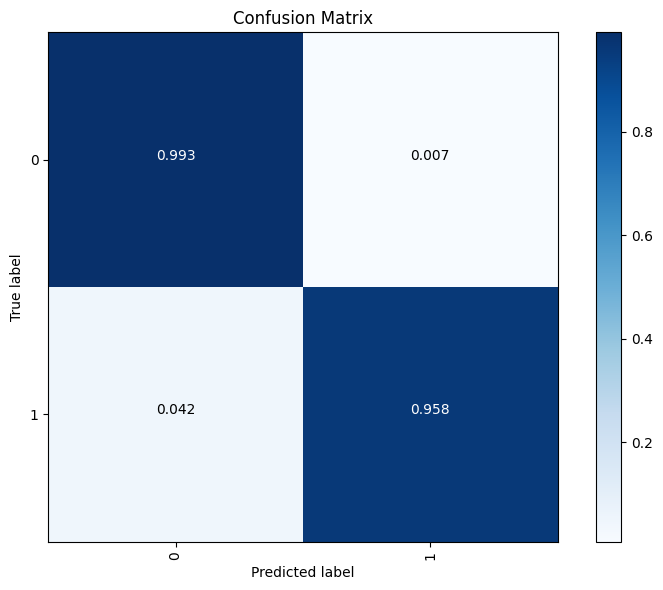


Classification report:

              precision    recall  f1-score   support

           0     0.9724    0.9926    0.9824      1347
           1     0.9886    0.9579    0.9730       902

    accuracy                         0.9787      2249
   macro avg     0.9805    0.9752    0.9777      2249
weighted avg     0.9789    0.9787    0.9786      2249



In [36]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.figure(figsize=figsize)
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 120:
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

# Saving the model and checking its performance with a sample input

In [37]:
trainer.save_model()

In [38]:
tokenizer.save_vocabulary(save_directory=f"./{output_dir}")

('./sms-spam-detection-distilbert/vocab.txt',)

In [39]:
pipe = pipeline("text-classification", output_dir, tokenizer=BERT_MODEL)
sample_title = '''Elon Musk buys Twitter, and so can you'''
pipe(sample_title, top_k=10)

[{'label': '0', 'score': 0.9938880801200867},
 {'label': '1', 'score': 0.006111975759267807}]

### TEST Results

In [45]:
%%time
df = pd.read_csv("/kaggle/input/iswpa-dataset/IWSPA-AP-Parsed.csv", encoding='latin-1')

item0 = df.shape[0] 
df = df.drop_duplicates()
item1 = df.shape[0]  
print(f"There are {item0-item1} duplicates found in the dataset") 

df = df.rename(columns={'is_phishing': 'label', 'email_body': 'title'})

df = df[['label', 'title']] 
df['label'] = df['label'].astype('str')


df = df[~df['title'].isnull()]  
df = df[~df['label'].isnull()] 

print(df.shape) 
df.sample(5).T  

There are 1019 duplicates found in the dataset
(9275, 2)
CPU times: user 221 ms, sys: 20 ms, total: 241 ms
Wall time: 249 ms


,1384,5288,5840,7103,1073
label,0,0,0,0,0
title,Finance Guest Account (GUEST)'s trip approval ...,"ST. 1st Class Herring, Its not a problem, I ca...","""Thanks"" Ben for this, hi all and happy new ye...",fatto Da: Lucia Rana [mailto:l.rana@hackingtea...,To be automatically unsubscribed from this lis...


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9275 entries, 0 to 10295
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9275 non-null   object
 1   title   9275 non-null   object
dtypes: object(2)
memory usage: 217.4+ KB


In [47]:
dataset = Dataset.from_pandas(df)

In [48]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=1, shuffle=True) # , stratify_by_column="label"

df_train = dataset['train']

df_test = dataset['test']

Map:   0%|          | 0/9275 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9275 [00:00<?, ? examples/s]

In [49]:

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=True, low_cpu_mem_usage=False)

In [50]:


def preprocess_function(examples):
   
    return tokenizer(examples["title"], truncation=True)



df_train = df_train.map(preprocess_function, batched=True)
df_test = df_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/9274 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [51]:
df_train = df_train.remove_columns(['title'])

df_test = df_test.remove_columns(['title'])

In [52]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [53]:
tokenizer.decode(df_train[0]['input_ids'])

'[CLS] Alessandro Scarafile updated a event in the 00. TENTATIVE calendar Jan 2013, 2015 Until Jan 2114, 2015 Support Morocco ( ALFAHAD ) Client needs help for firewall configuration and system check. Refer to ticket YMN - 265 - 89975. You are receiving this notification because you are watching the following : 00. TENTATIVE Sent by Atlassian Confluence 5. 6. 3, the Enterprise Wiki [SEP]'

In [54]:
outputs = trainer.predict(df_train)

print(outputs.metrics)

{'test_loss': 0.36423200368881226, 'test_accuracy': 0.9110416217381928, 'test_runtime': 87.7481, 'test_samples_per_second': 105.689, 'test_steps_per_second': 1.652}


Accuracy: 0.9110
F1 Score: 0.7756


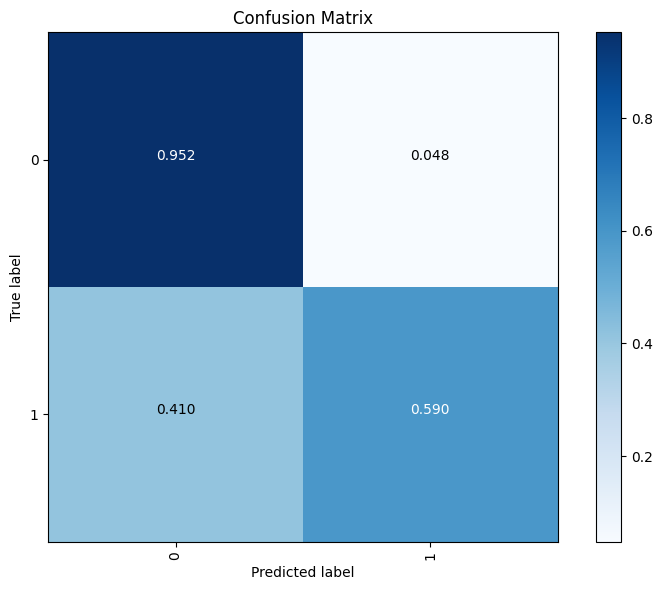


Classification report:

              precision    recall  f1-score   support

           0     0.9477    0.9522    0.9499      8220
           1     0.6128    0.5901    0.6013      1054

    accuracy                         0.9110      9274
   macro avg     0.7803    0.7712    0.7756      9274
weighted avg     0.9096    0.9110    0.9103      9274



In [55]:
y_true = outputs.label_ids

y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8), is_norm=True):
  
    plt.figure(figsize=figsize)
    
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    if is_norm:
        fmt = '.3f'
    else:
        fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 120:
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))